In [11]:
import pandas as pd
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def function(x1: float, x2: float) -> float:
    return -np.abs(x1 - 50) - np.abs(x2 - 50)

In [13]:

def mu_plus_lambda(
        u: int,
        lam: int,
        turniej_rozmiar: int,
        mutacja_poziom: float,
        iteracje_liczba: int,
        function: Callable[[float, float], float]
) -> dict[int, pd.DataFrame]:
    # 1. Stwórz w sposób losowy pulę rodzicielską składającą się z µ osobników. W podanym przykładzie każdy osobnik zawiera dwie liczby x1, x2 , o wartościach wybranych z przedziału [0; 100].
    osobniki = np.random.uniform(0, 100, size=(u, 2))
    df = pd.DataFrame(osobniki, columns=["x1", "x2"])

    df["fit"] = df.apply(lambda row: function(row["x1"], row["x2"]), axis=1)

    history = {}
    # 2. Wykonaj pętlę iteracje_liczba razy.
    for i in range(iteracje_liczba):
        # 2.2. Stwórz pustą pulę osobników potomnych.
        osobniki_potomne = []

        # 2.3. Dodaj do puli potomnej λ nowych osobników.
        for _ in range(lam):
            # 2.3.1. Wybierz osobnika os_n z puli rodzicielskiej za pomocą algorytmu turniejowego.
            # 2.3.1.1. Utwórz zbiór osobników oss_turniej  przez losowy wybór turniej_rozmiar osobników z puli rodzicielskiej.
            oss_turniej = df.sample(n=turniej_rozmiar)

            # 2.3.1.2. Niech os_n będzie najlepszym osobnikiem ze zbioru oss_turniej biorąc pod uwagę funkcję przystosowania F(). W razie remisu należ wybrać któryś z najlepszych osobników w oss_turniej.
            winner = oss_turniej.nlargest(1, "fit").iloc[0]
            x1_new = winner["x1"]
            x2_new = winner["x2"]

            # 2.3.2. Dokonaj mutacji na os_n poprzez dodanie do  x1,x2 tego osobnika drobnej wartości z przedziału [-mutacja_poziom; +mutacja_poziom]
            x1_new += np.random.uniform(-mutacja_poziom, mutacja_poziom)
            x2_new += np.random.uniform(-mutacja_poziom, mutacja_poziom)
            x1_new = np.clip(x1_new, 0, 100)
            x2_new = np.clip(x2_new, 0, 100)

            osobniki_potomne.append([x1_new, x2_new])

        df_potomne = pd.DataFrame(osobniki_potomne, columns=["x1", "x2"])

        # 2.4. Oceń wszystkich osobników w puli potomnej.
        df_potomne["fit"] = df_potomne.apply(lambda row: function(row["x1"], row["x2"]), axis=1)

        # 2.5. Niech nową pulą rodzicielską będzie µ najlepszych osobników wybranych z połączonego zbioru osobników rodzicielskich i potomnych (stąd nazwa „strategia µ+λ”)
        df_combined = pd.concat([df, df_potomne], ignore_index=True)
        df = df_combined.nsmallest(u, "fit").reset_index(drop=True)

        if i in [0, 3, 13]:
            history[i] = {
                "rodzice": df.copy(),
                "potomkowie": df_potomne.copy()
            }

    # 3. Wybierz najlepszego osobnika z puli rodzicielskiej jako ostateczne rozwiązanie.
    best_solution = df.nsmallest(1, "fit").iloc[0]
    print(f"współrzędne najlepszego osobnika x1: {best_solution["x1"]}, x2: {best_solution["x2"]}")

    return history


In [14]:
u = 4
lam = 10
turniej_rozmiar = 2
mutacja_poziom = 100/10
iteracje_liczba = 20
history = mu_plus_lambda(u, lam, turniej_rozmiar, mutacja_poziom, iteracje_liczba, function)

współrzędne najlepszego osobnika x1: 100.0, x2: 100.0


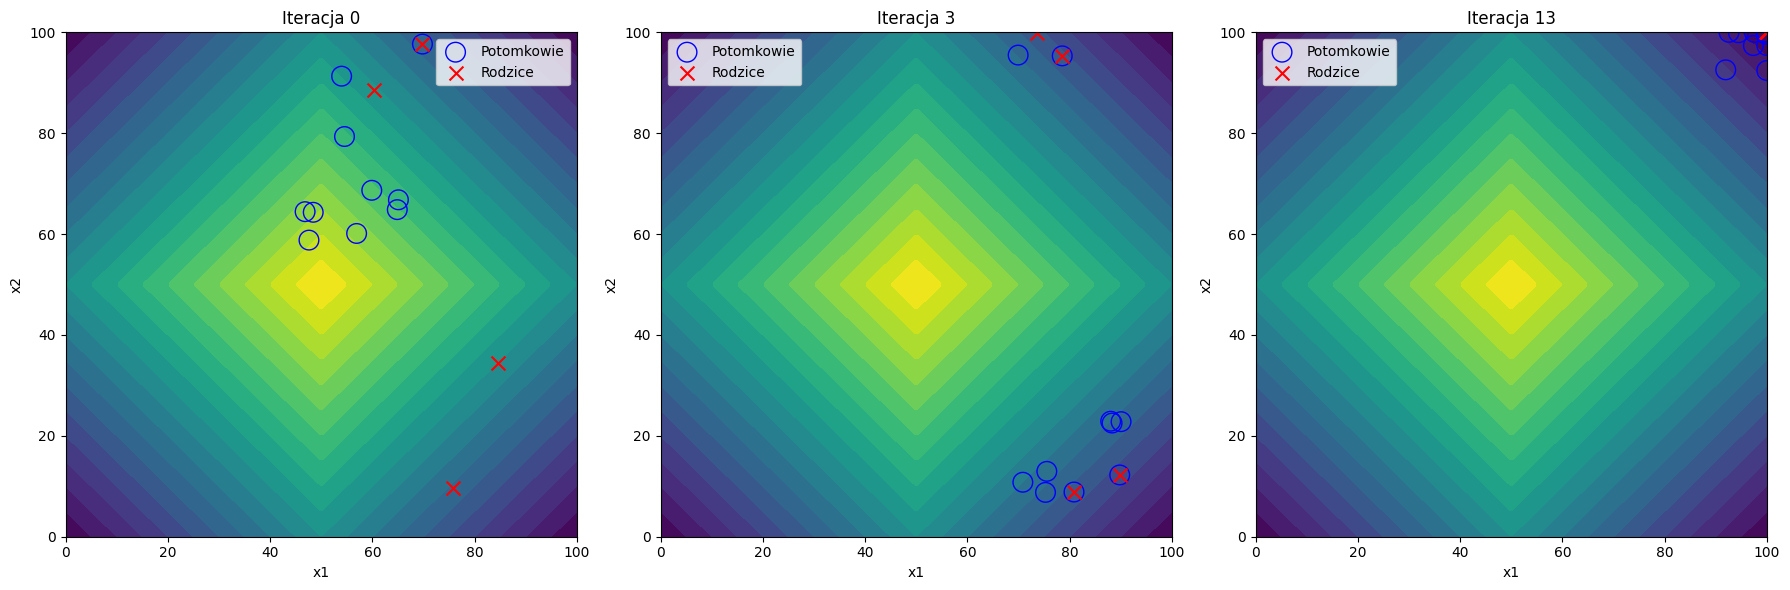

In [15]:
x = np.linspace(0, 100, 200)
y = np.linspace(0, 100, 200)
X, Y = np.meshgrid(x, y)
Z = function(X, Y)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
iters_to_plot = [0, 3, 13]

for ax, it in zip(axes, iters_to_plot):
    cp = ax.contourf(X, Y, Z, levels=20)

    data = history.get(it)
    potomkowie = data["potomkowie"]
    ax.scatter(potomkowie["x1"], potomkowie["x2"], s=200, label="Potomkowie", marker="o", facecolors="none", edgecolors="blue")

    rodzice = data["rodzice"]
    ax.scatter(rodzice["x1"], rodzice["x2"], s=100, label="Rodzice", marker="x", color="red")

    ax.set_title(f"Iteracja {it}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.legend()

plt.tight_layout()
plt.savefig("mu_plus_lambda.png")